In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


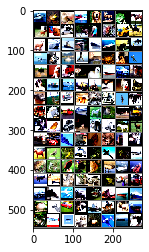

 ship  frog  bird  ship


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 5, padding = 2)
        self.pool = nn.MaxPool2d(3, stride = 2)
        self.conv2 = nn.Conv2d(64, 64, 5, padding = 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding = 2)
        self.fc1 = nn.Linear(1152, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 1152)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# net = Net()
# net = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=False)
net = models.resnet18()
net.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)

# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[80,120], gamma=0.1)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 10)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.01, step_size_up=10, step_size_down=10)

In [ ]:
EPOCH = 150

train_loss = []
test_loss = []

train_acc = []
test_acc = []

lr = []

# for g in optimizer.param_groups:
#     g['lr'] = 0.01

for epoch in range(EPOCH):  # loop over the dataset multiple times

    print('Epoch %d' % (epoch+1))
    print('learning rate :', optimizer.param_groups[0]['lr'])
    lr.append(optimizer.param_groups[0]['lr'])

    # loss for show
    running_loss = 0.0
    
    # loss for draw graph
    sum_train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs.cuda()).cpu()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # print statistics
        sum_train_loss += loss.item()
        
        
    print('Accuracy of the network on the train images: %d %%' % (100 * train_correct / train_total))
    
            
    train_loss.append(sum_train_loss / i)
    train_acc.append(train_correct / train_total)
    
    # loss for draw graph
    sum_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            images, labels = data
            outputs = net(images.cuda()).cpu()
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            sum_loss += loss.item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    
    test_loss.append(sum_loss / i)
    test_acc.append(correct / total)

    scheduler.step()
    # scheduler.step(loss)

#     for warmup
#     if epoch < 5 :
#         for g in optimizer.param_groups:
#             g['lr'] = 0.01
    

print('Finished Training')

Epoch 1
learning rate : 0.1
Accuracy of the network on the train images: 31 %
Accuracy of the network on the 10000 test images: 45 %
Epoch 2
learning rate : 0.09755282581475769
Accuracy of the network on the train images: 46 %
Accuracy of the network on the 10000 test images: 51 %
Epoch 3
learning rate : 0.09045084971874738
Accuracy of the network on the train images: 52 %
Accuracy of the network on the 10000 test images: 56 %
Epoch 4
learning rate : 0.07938926261462366
Accuracy of the network on the train images: 57 %
Accuracy of the network on the 10000 test images: 61 %
Epoch 5
learning rate : 0.06545084971874737
Accuracy of the network on the train images: 62 %
Accuracy of the network on the 10000 test images: 64 %
Epoch 6
learning rate : 0.05
Accuracy of the network on the train images: 66 %
Accuracy of the network on the 10000 test images: 68 %
Epoch 7
learning rate : 0.03454915028125263
Accuracy of the network on the train images: 69 %
Accuracy of the network on the 10000 test i

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images.cuda()).cpu()

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda()).cpu()
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(train_loss, c='r', label='train')
ax1.plot(test_loss, c='b', label='test')
ax2.plot(train_acc, c='r', label='train')
ax2.plot(test_acc, c='b', label='test')

ax1.title.set_text('Loss')
ax2.title.set_text('Accuracy')

# ax1.set_ylim([0,2])
ax2.set_ylim([0,1.1])

ax1.legend()
ax2.legend()

plt.show()

print('_train = ', train_loss)
print('_test = ', test_loss)
print('_train_acc = ', train_acc)
print('_test_acc = ', test_acc)
print('_lr = ', lr)